In [4]:
"""
    for BCI competition 2b
"""

import mne
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

# 设置事件
eventDescription = {
    '276': "eyesOpen", 
    '277': "eyesClosed", 
    '768': "startTrail", 
    '769':"cueLeft", 
    '770':"cueRight", 
    '781':"feedback",
    '783':"cueUnknown",
    '1023': "rejected",
    '1077': 'horizonEyeMove',
    '1078': "verticalEyeMove",
    '1079':"eyeRotation",
    '1081':"eyeBlinks",
    '32766':"startRun"
}

# 设置4种不同波段的频率范围
iter_freqs = {
    'Theta':[4,7],
    'Alpha':[8, 12],
    'Beta': [13, 25],
    'Gamma':[30, 45],
}


Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0101T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.


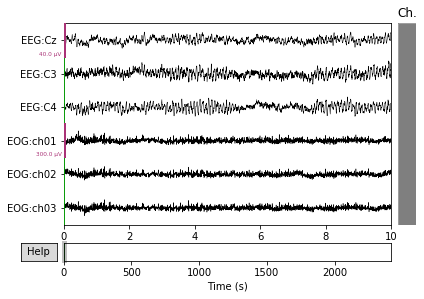

In [5]:
person=1
trail=1

tmin = -1.0
tmax = 3

data_path = r"E:\bci2b\BCICIV_2b_gdf\B0{}0{}T.gdf".format(person,trail)
rawDataGDF = mne.io.read_raw_gdf(data_path,preload=True,eog=['EOG:ch1', 'EOG:ch02', 'EOG:ch03'])
print(rawDataGDF.info)
ch_types = ['eeg', 'eeg', 'eeg','eog','eog','eog']
ch_names = ['EEG:Cz', 'EEG:C3', 'EEG:C4','EOG:ch01', 'EOG:ch02', 'EOG:ch03']

info = mne.create_info(ch_names=ch_names, sfreq=rawDataGDF.info['sfreq'], ch_types=ch_types)
data = np.squeeze(np.array([rawDataGDF['EEG:Cz'][0], 
                            rawDataGDF['EEG:C3'][0], 
                            rawDataGDF['EEG:C4'][0],
                            rawDataGDF['EOG:ch01'][0] , 
                            rawDataGDF['EOG:ch02'][0] ,
                            rawDataGDF['EOG:ch03'][0]]))
rawData = mne.io.RawArray(data, info)
rawData.plot()
plt.show()


Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
['EEG:Cz', 'EEG:C3', 'EEG:C4', 'EOG:ch01', 'EOG:ch02', 'EOG:ch03']


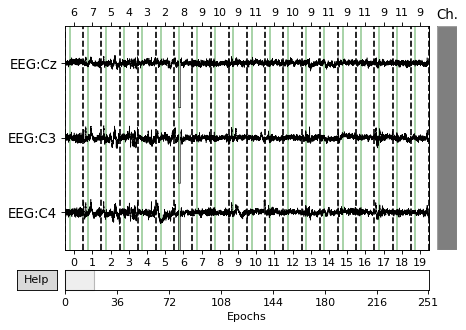

In [6]:
event,_= mne.events_from_annotations(rawDataGDF)
event_id = {}
for i in _:
    event_id[eventDescription[i]] = _[i]
epochs = mne.Epochs(rawData,event,event_id,tmin = tmin, tmax=tmax ,event_repeated = 'merge',preload=True)
print([x for x in epochs.ch_names])
epochs.plot()
plt.show()

Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 255 samples (1.020 sec)

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: EOG:ch01, EOG:ch02, EOG:ch03
[done]


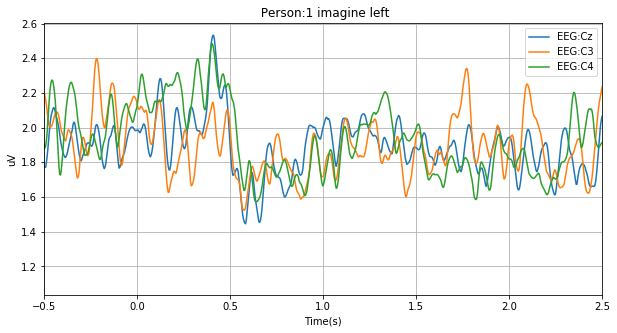

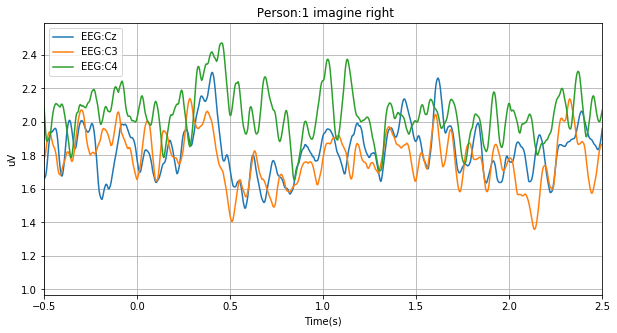

In [7]:
def plot_epochs(epoch,freq='Beta',tmin=-1,tmax=3):
    ########    preprocess    ##########
    global iter_freqs
    if (freq=='all'):
        epoch = epoch.filter(5.,45.,fir_design='firwin',skip_by_annotation='edge')
    else:
        epoch = epoch.filter(iter_freqs[freq][0],iter_freqs[freq][1],fir_design='firwin',skip_by_annotation='edge')
    epoch.subtract_evoked()
    
    ########  end preprocess  ##########
    
    def plot_ev(ev,label):
        t = np.arange(tmin,tmax,(tmax-tmin)/ev.data.shape[1])
        plt.figure(figsize=(10,5))
        
        for i in range(ev.data.shape[0]):
            y = ev.data[i,:];
            plt.plot(t,y*1000000,label=epoch.ch_names[i])
        
        plt.xlim(xmin=tmin+0.5,xmax=tmax-0.5)
        #plt.ylim(ymin=1.0,ymax=3.5)
        plt.xlabel('Time(s)')
        plt.ylabel('uV')
        plt.title(' Person:{} imagine {}'.format(person,label))
        plt.grid(True)
        plt.legend()
        plt.show()
    import scipy.io as sio
    sio.savemat(r"E:\bci2b\BCICIV_2b_mat_beta\B0{}0{}T.mat".format(person,trail),
                {
                    "left":epoch['cueLeft'].get_data(),
                    "right":epoch['cueRight'].get_data(),
                })
    epoch.apply_hilbert(envelope=True)
    plot_ev(epoch['cueLeft'].average(),'left')
    plot_ev(epoch['cueRight'].average(),'right')

plot_epochs(epochs)
    

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0101T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

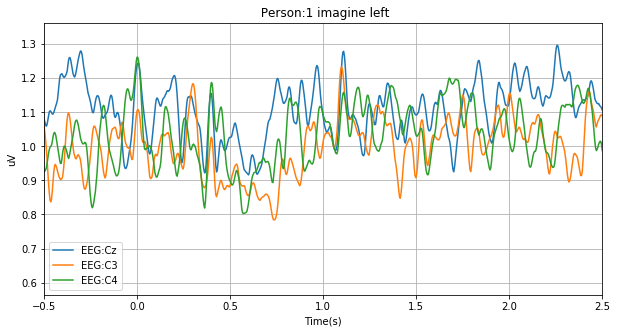

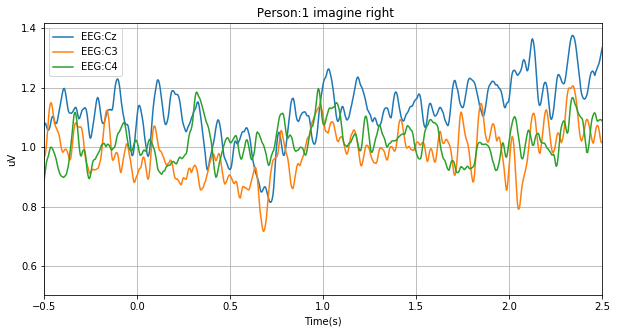

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0102T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-07 16:38:57 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=552452
    Range : 0 ... 552451 =      0.000 ...  2209.804 secs
Ready.
Used Annotations descriptions: ['1023', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
246 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 246 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pass

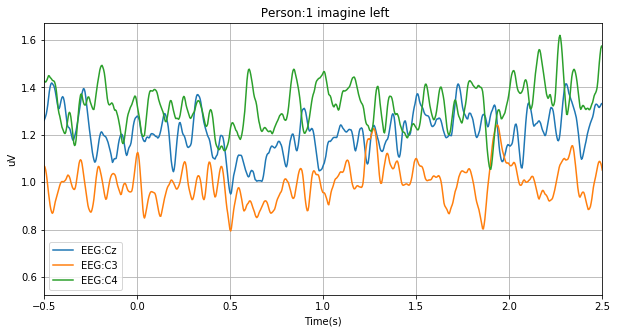

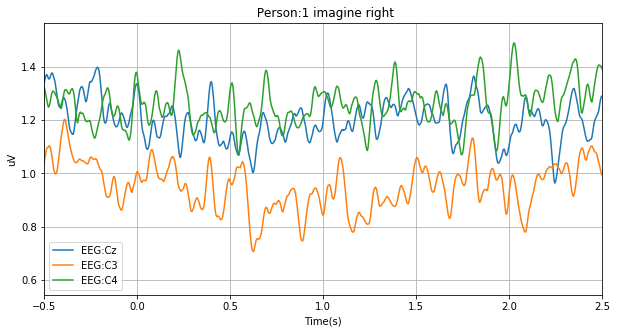

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0103T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469010  =      0.000 ...  1876.040 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-30 10:44:29 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=469011
    Range : 0 ... 469010 =      0.000 ...  1876.040 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

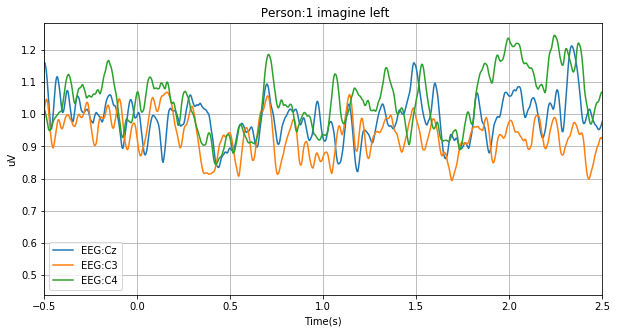

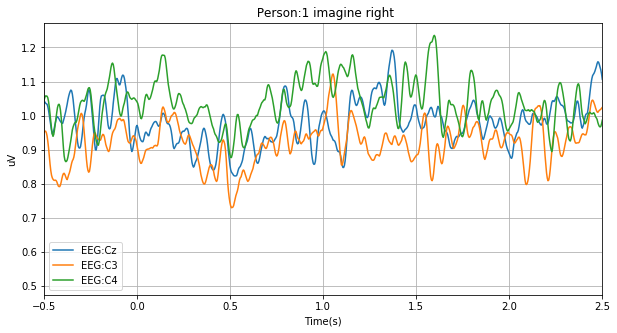

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0201T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-10-25 11:59:13 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

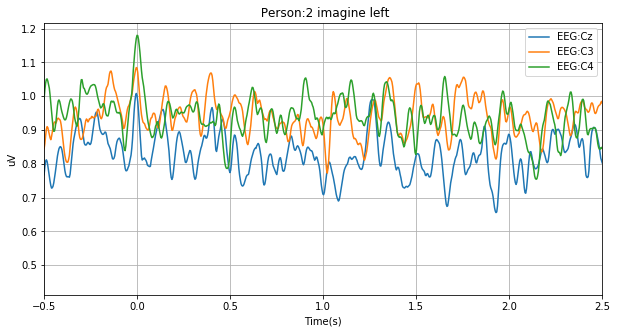

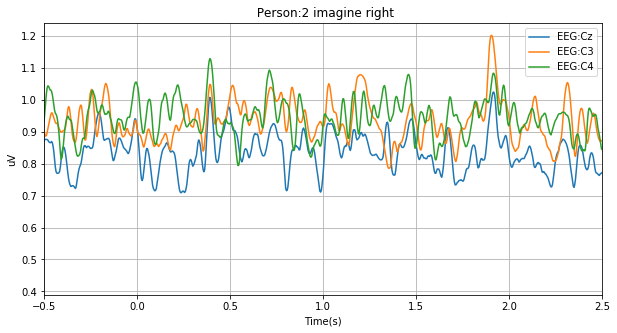

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0202T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-10-31 10:47:27 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

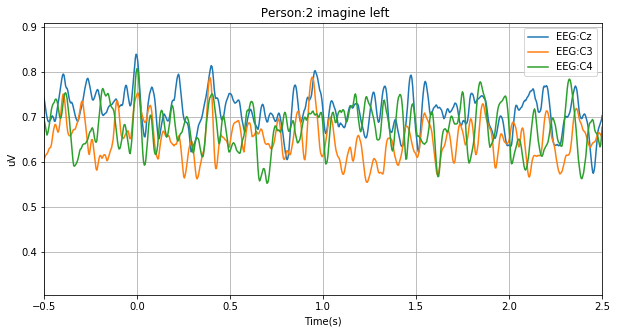

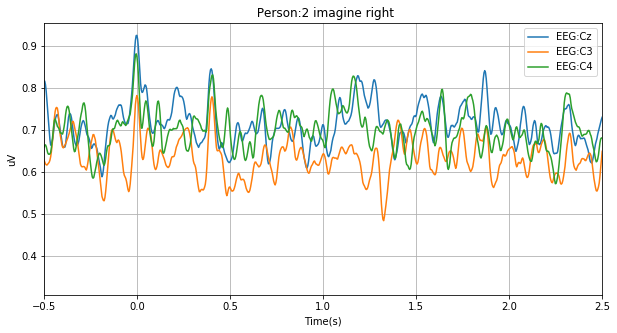

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0203T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464154  =      0.000 ...  1856.616 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-06 08:58:14 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=464155
    Range : 0 ... 464154 =      0.000 ...  1856.616 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

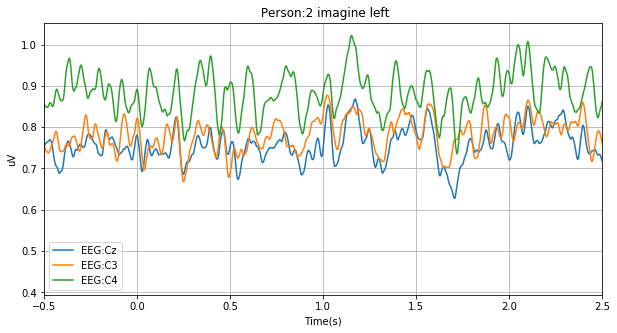

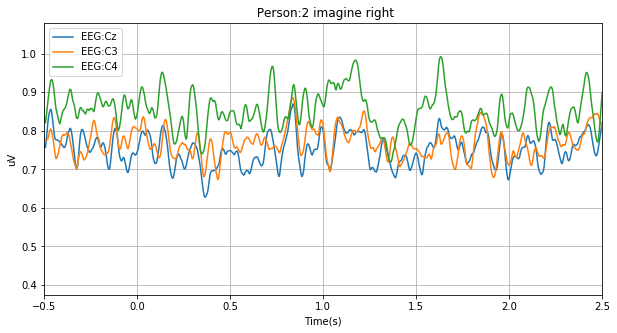

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0301T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-02 15:37:16 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

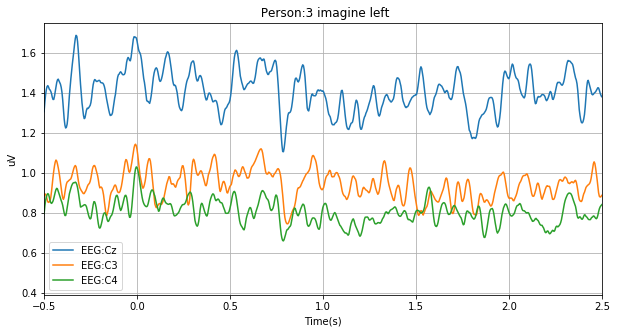

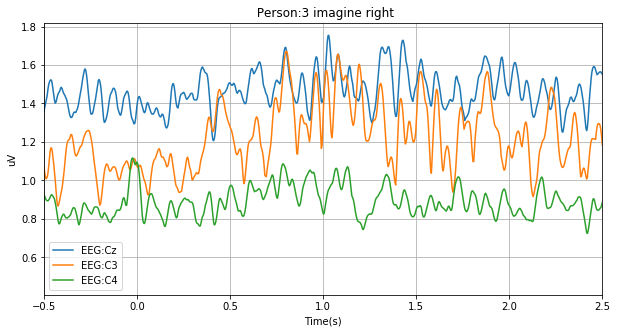

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0302T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-17 10:12:22 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

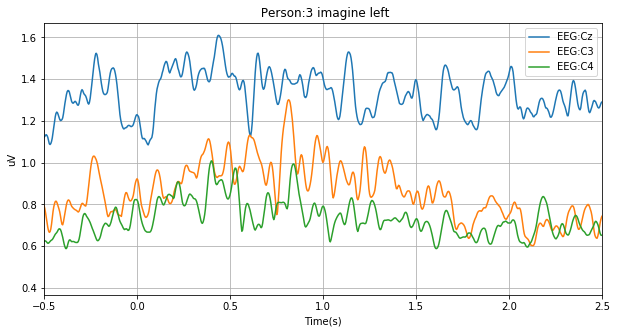

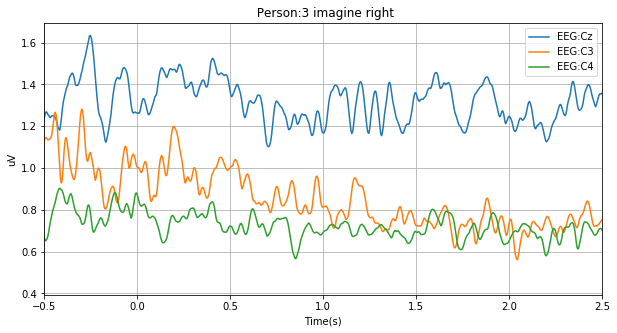

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0303T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-13 13:54:33 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=464675
    Range : 0 ... 464674 =      0.000 ...  1858.696 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

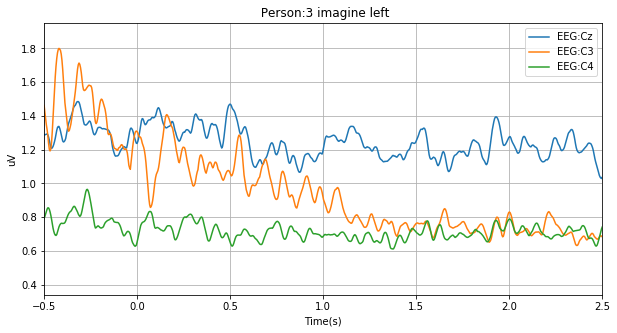

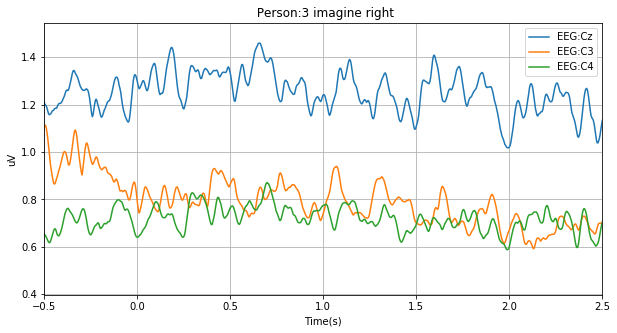

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0401T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-03 11:29:51 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

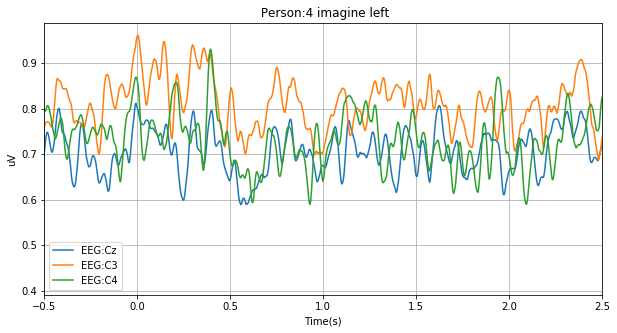

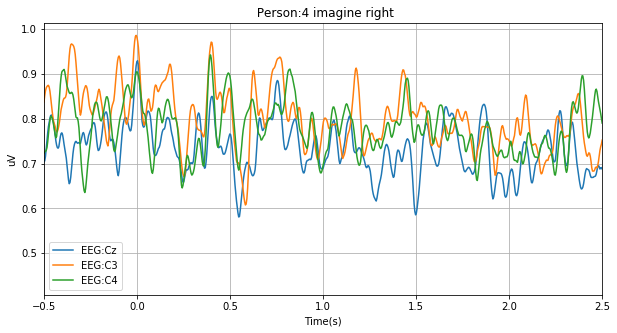

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0402T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696265  =      0.000 ...  2785.060 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-07 12:38:31 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=696266
    Range : 0 ... 696265 =      0.000 ...  2785.060 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
294 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 294 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

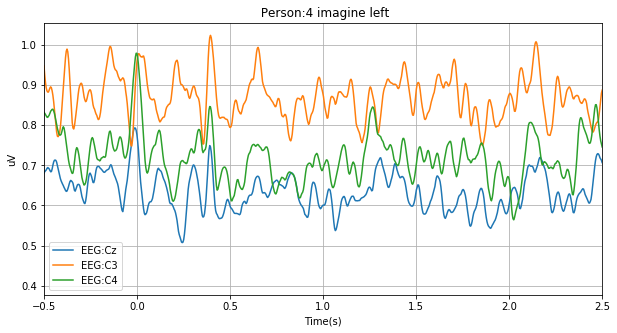

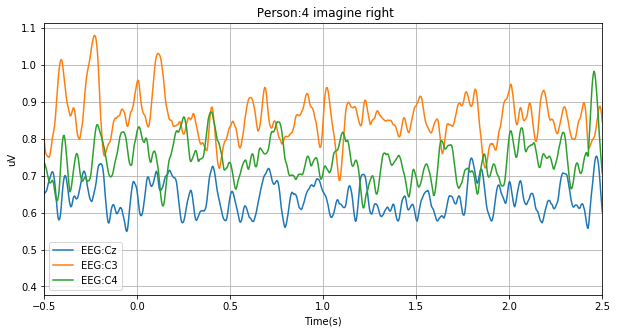

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0403T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 468558  =      0.000 ...  1874.232 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-30 12:28:35 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=468559
    Range : 0 ... 468558 =      0.000 ...  1874.232 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

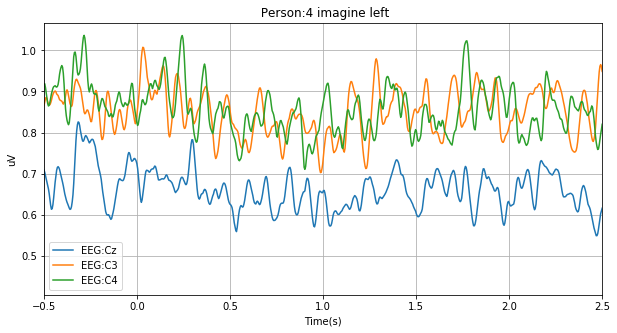

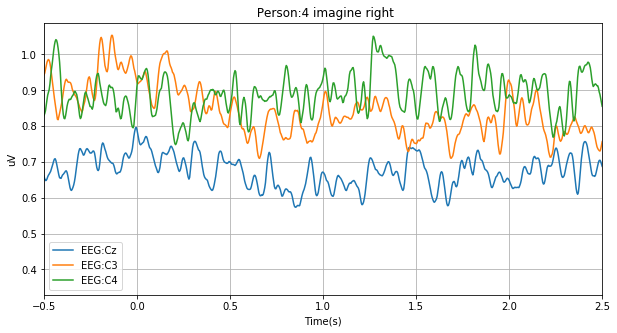

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0501T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-10-24 13:03:40 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

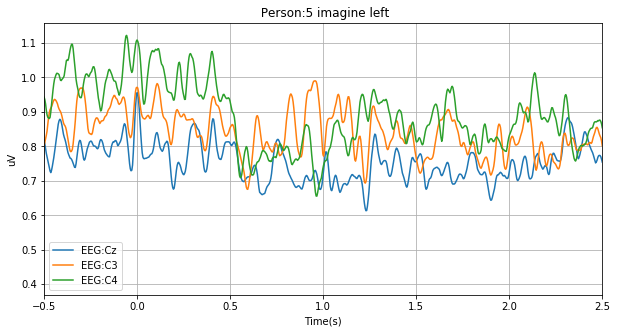

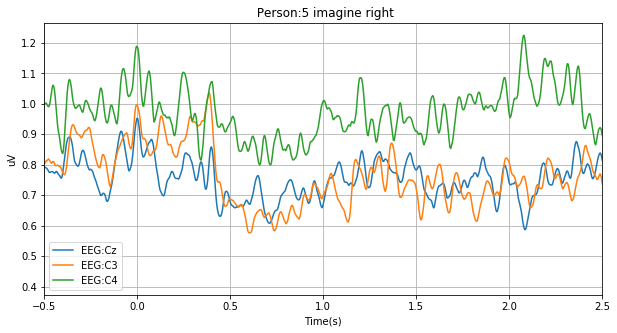

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0502T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696265  =      0.000 ...  2785.060 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-02 12:55:35 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=696266
    Range : 0 ... 696265 =      0.000 ...  2785.060 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
294 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 294 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

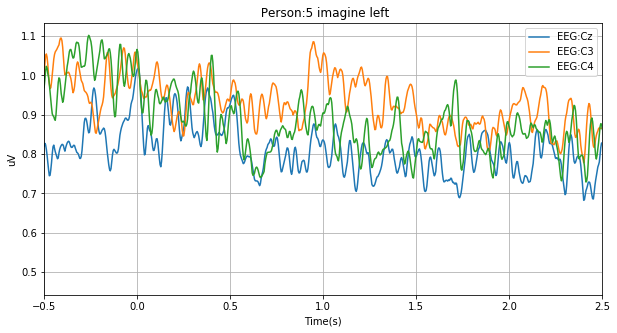

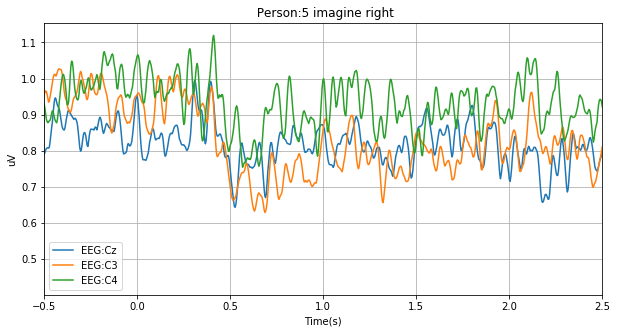

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0503T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 461874  =      0.000 ...  1847.496 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-29 11:09:04 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=461875
    Range : 0 ... 461874 =      0.000 ...  1847.496 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

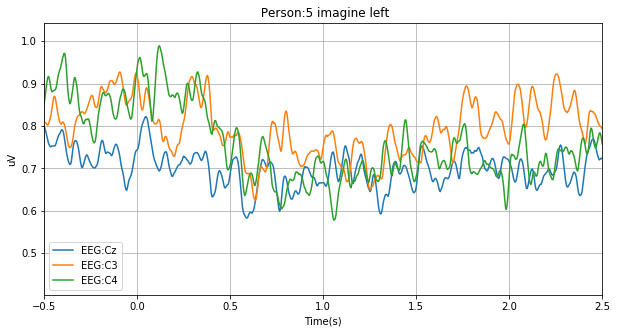

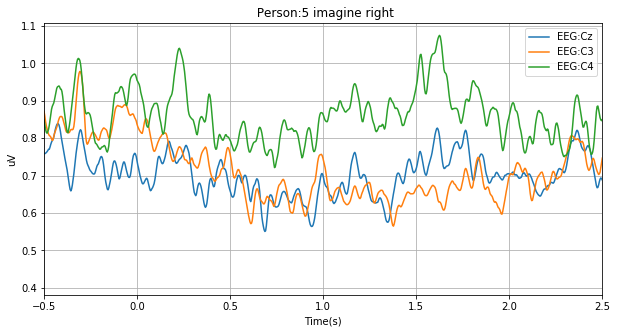

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0601T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-10-28 10:03:22 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

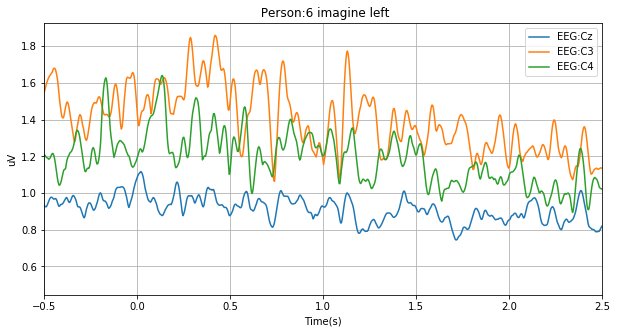

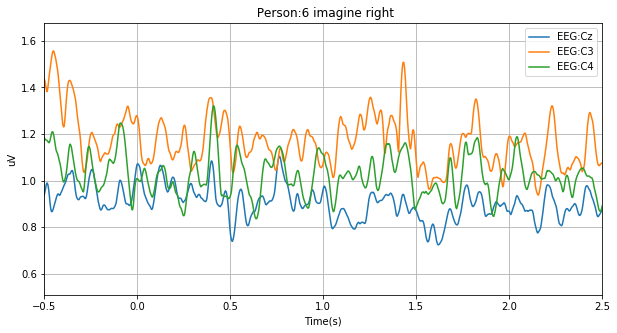

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0602T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-02 10:19:07 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

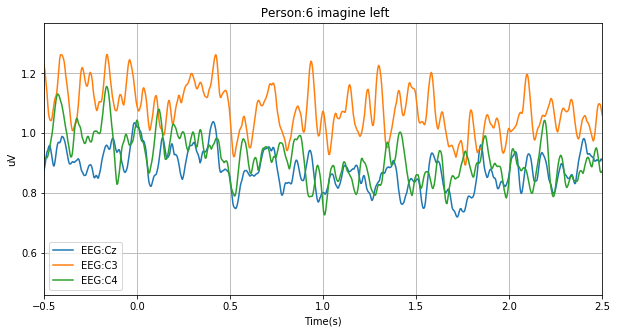

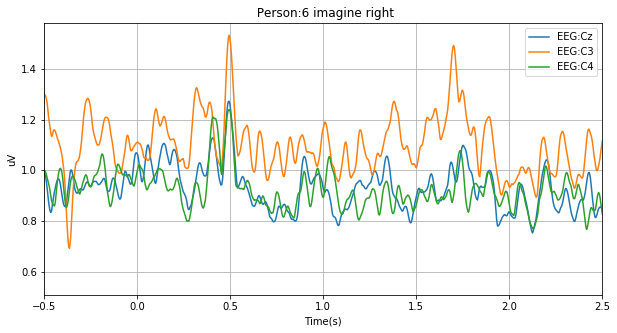

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0603T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 470390  =      0.000 ...  1881.560 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-02 10:59:18 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=470391
    Range : 0 ... 470390 =      0.000 ...  1881.560 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

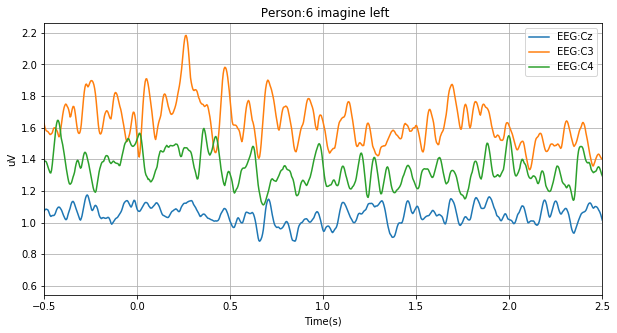

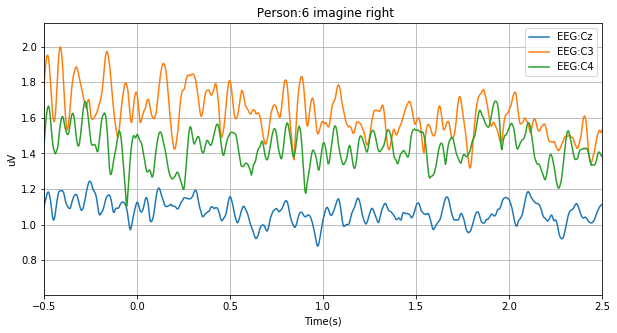

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0701T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-22 10:06:12 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

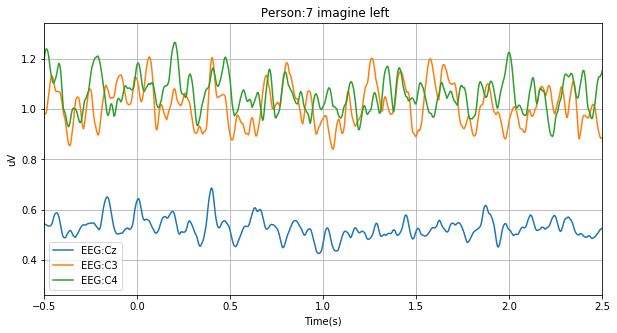

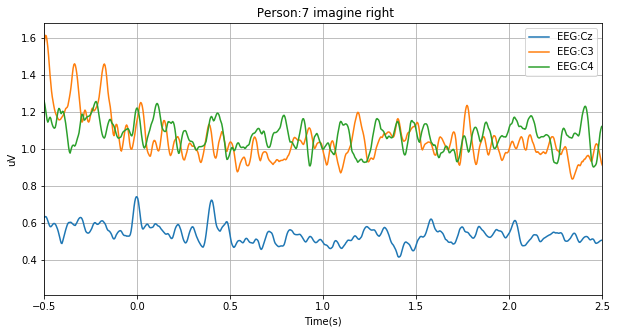

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0702T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-24 10:31:57 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

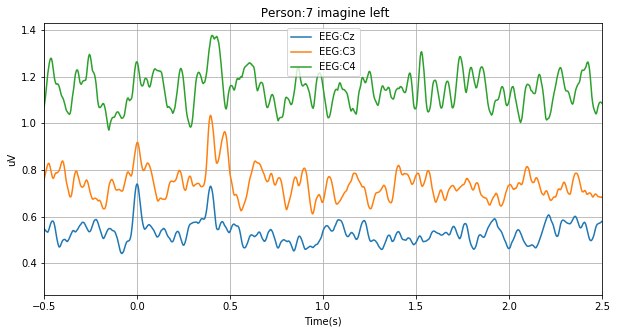

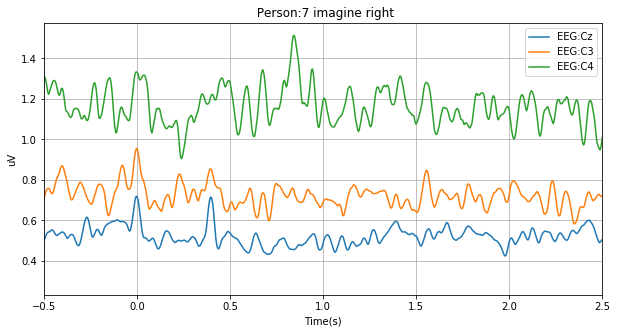

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0703T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 466726  =      0.000 ...  1866.904 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-22 09:10:00 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=466727
    Range : 0 ... 466726 =      0.000 ...  1866.904 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

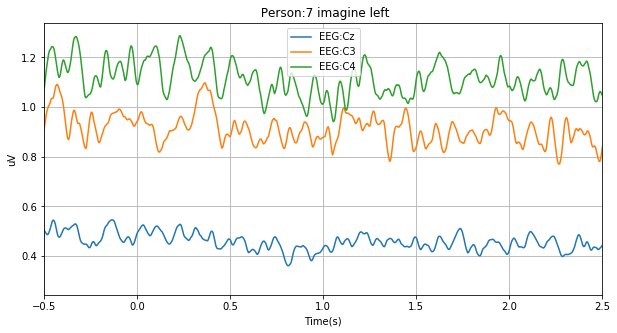

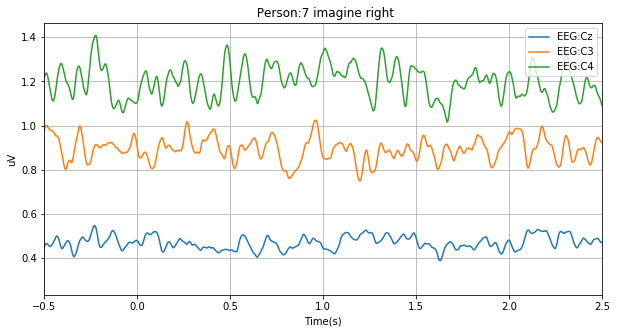

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0801T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 787728  =      0.000 ...  3150.912 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-21 09:19:10 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=787729
    Range : 0 ... 787728 =      0.000 ...  3150.912 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
335 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 335 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

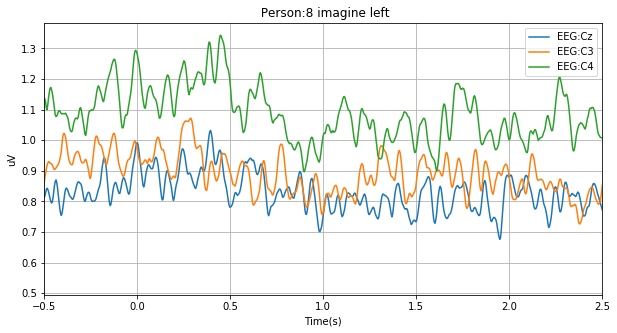

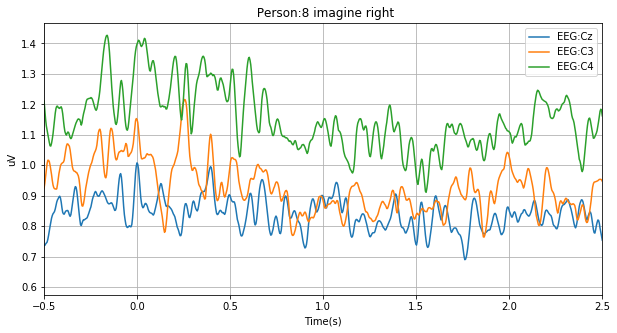

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0802T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-02 10:18:33 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

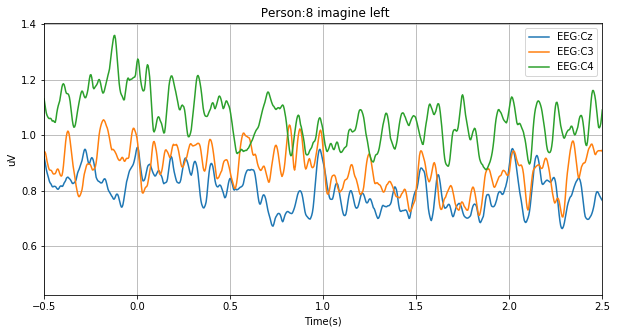

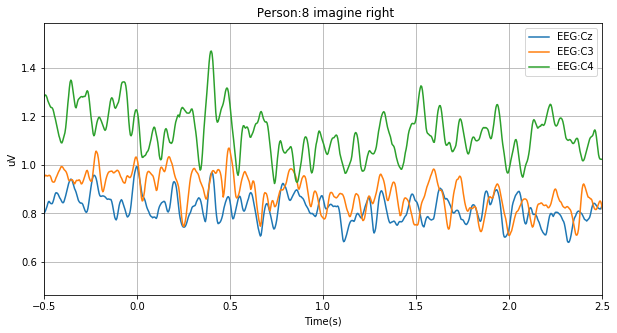

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0803T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 474834  =      0.000 ...  1899.336 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2006-01-20 10:16:58 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=474835
    Range : 0 ... 474834 =      0.000 ...  1899.336 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

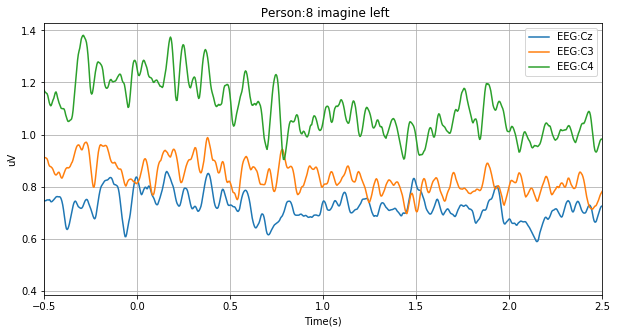

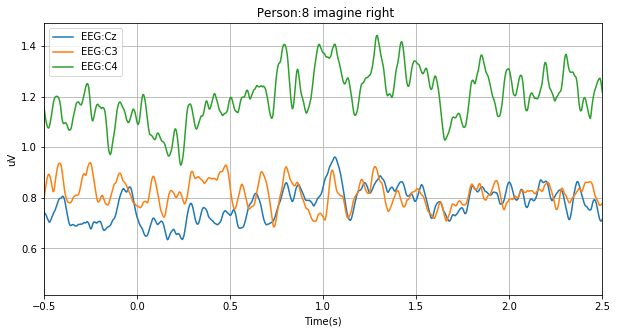

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0901T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-29 14:19:32 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

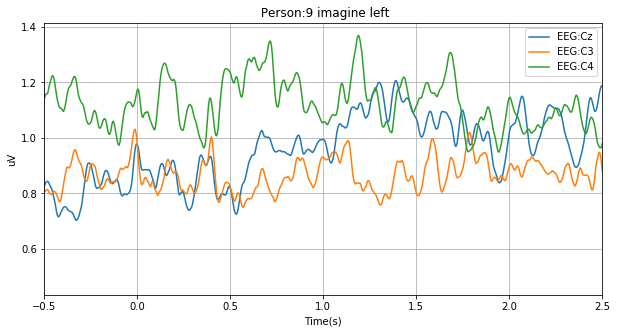

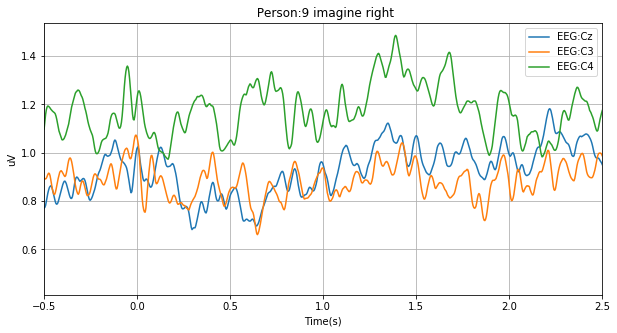

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0902T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-06 10:16:49 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=604803
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
253 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 253 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

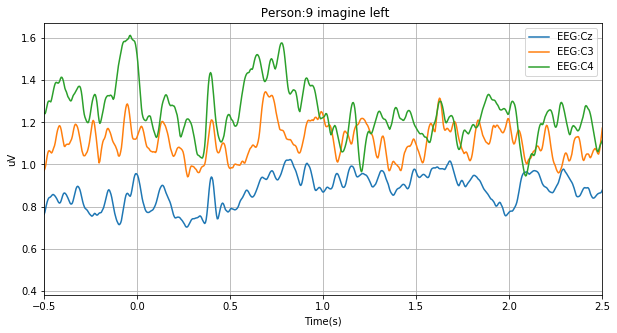

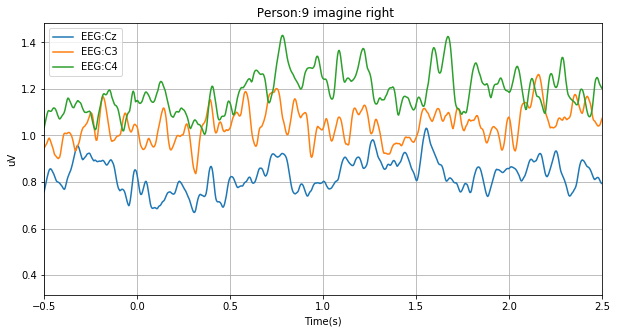

Extracting EDF parameters from E:\bci2b\BCICIV_2b_gdf\B0903T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460730  =      0.000 ...  1842.920 secs...


C:\Users\hanzezhen\anaconda3\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 4 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-12-09 09:20:50 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=6, n_times=460731
    Range : 0 ... 460730 =      0.000 ...  1842.920 secs
Ready.
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770', '781']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
491 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 491 events and 1001 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

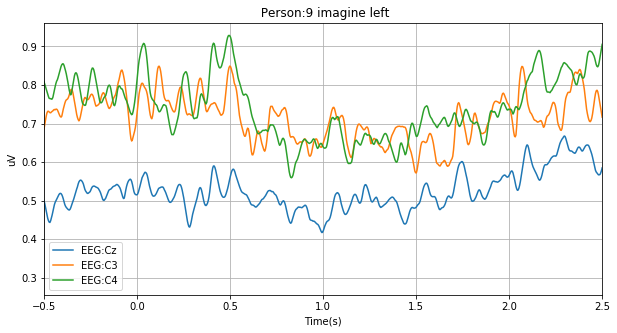

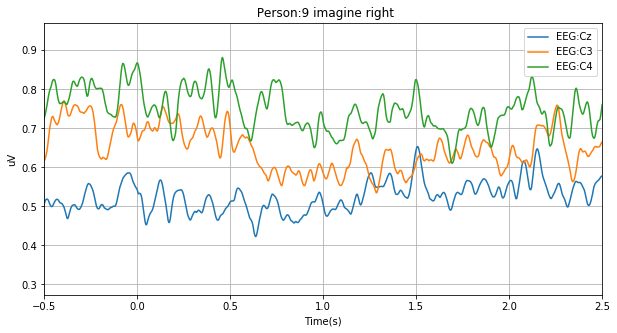

In [11]:
for person in range(1,10):
    for trail in range(1,4):

        tmin = -1.0
        tmax = 3

        data_path = r"E:\bci2b\BCICIV_2b_gdf\B0{}0{}T.gdf".format(person,trail)
        rawDataGDF = mne.io.read_raw_gdf(data_path,preload=True,eog=['EOG:ch1', 'EOG:ch02', 'EOG:ch03'])
        print(rawDataGDF.info)
        ch_types = ['eeg', 'eeg', 'eeg','eog','eog','eog']
        ch_names = ['EEG:Cz', 'EEG:C3', 'EEG:C4','EOG:ch01', 'EOG:ch02', 'EOG:ch03']

        info = mne.create_info(ch_names=ch_names, sfreq=rawDataGDF.info['sfreq'], ch_types=ch_types)
        data = np.squeeze(np.array([rawDataGDF['EEG:Cz'][0], 
                                    rawDataGDF['EEG:C3'][0], 
                                    rawDataGDF['EEG:C4'][0],
                                    rawDataGDF['EOG:ch01'][0] , 
                                    rawDataGDF['EOG:ch02'][0] ,
                                    rawDataGDF['EOG:ch03'][0]]))
        rawData = mne.io.RawArray(data, info)


        event,_= mne.events_from_annotations(rawDataGDF)
        event_id = {}
        for i in _:
            event_id[eventDescription[i]] = _[i]
        epochs = mne.Epochs(rawData,event,event_id,tmin = tmin, tmax=tmax ,event_repeated = 'merge',preload=True)




        def plot_epochs(epoch,freq='Gamma',tmin=-1,tmax=3):
            ########    preprocess    ##########
            global iter_freqs
            if (freq=='all'):
                epoch = epoch.filter(5.,45.,fir_design='firwin',skip_by_annotation='edge')
            else:
                epoch = epoch.filter(iter_freqs[freq][0],iter_freqs[freq][1],fir_design='firwin',skip_by_annotation='edge')
            epoch.subtract_evoked()

            ########  end preprocess  ##########

            def plot_ev(ev,label):
                t = np.arange(tmin,tmax,(tmax-tmin)/ev.data.shape[1])
                plt.figure(figsize=(10,5))

                for i in range(ev.data.shape[0]):
                    y = ev.data[i,:];
                    plt.plot(t,y*1000000,label=epoch.ch_names[i])

                plt.xlim(xmin=tmin+0.5,xmax=tmax-0.5)
                #plt.ylim(ymin=1.0,ymax=3.5)
                plt.xlabel('Time(s)')
                plt.ylabel('uV')
                plt.title(' Person:{} imagine {}'.format(person,label))
                plt.grid(True)
                plt.legend()
                plt.show()
            import scipy.io as sio
            sio.savemat(r"E:\bci2b\BCICIV_2b_mat_Gamma\B0{}0{}T.mat".format(person,trail),
                        {
                            "left":epoch['cueLeft'].get_data(),
                            "right":epoch['cueRight'].get_data(),
                        })
            epoch.apply_hilbert(envelope=True)
            plot_ev(epoch['cueLeft'].average(),'left')
            plot_ev(epoch['cueRight'].average(),'right')

        plot_epochs(epochs)